In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.express as plx
import neattext.functions as nfx
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
#from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pickle
import keras
from keras.models import Sequential
import tensorflow as tf
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
import plotly.express as px


In [21]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [22]:
path = 'C:/Users/olver/OneDrive/Escritorio/Data_Suicide/Suicide_Detection.csv'
data = pd.read_csv(path)
#eliminamos el id
data.head()

Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide

In [23]:
#obtenemos la longitud en palabras
data['count_words'] = data['text'].str.split().str.len()

#hacemos un boxplot
fig = px.violin(data, y="count_words",
             title = 'Número de palabras por post',
             labels={
                     "count_words": "No. de palabras"
                 })
fig.show()

In [24]:
#Usamos el metodo IQR para eliminar los outliers de count_words
Q1 = data['count_words'].quantile(0.25)
Q3 = data['count_words'].quantile(0.75)
IQR = Q3 - Q1

data = data[~((data['count_words'] < (Q1 - 1.5 * IQR)) |(data['count_words'] > (Q3 + 1.5 * IQR)))]
data = data.reset_index(drop=True)

#Hacemos boxplot de count_words
fig = px.violin(data, y="count_words",
            title = 'Número de palabras por post (sin outliers)',
            labels={
                     "count_words": "No. de palabras"
                 })
fig.show()

In [9]:
#Verificamos que el dataset no se haya desbalanceado tanto 
data['class'].value_counts(normalize = True)

class
non-suicide    0.558153
suicide        0.441847
Name: proportion, dtype: float64

In [10]:
#Dividimos en train y test
train_data,test_data=train_test_split(data,test_size=0.2,random_state=7, stratify=data['class'])

#imprimimos la distribución de las clases por test y train
print(f'***Train Data***')
print(len(train_data))
display(train_data['class'].value_counts(normalize = True))

print('*'*40)
print(f'***Test Data***')
print(len(test_data))
display(test_data['class'].value_counts(normalize = True))

***Train Data***
161264


class
non-suicide    0.558153
suicide        0.441847
Name: proportion, dtype: float64

****************************************
***Test Data***
40317


class
non-suicide    0.558152
suicide        0.441848
Name: proportion, dtype: float64

In [11]:
train_data

Unnamed: 0                                               text  \
112849      195102  my wave of depression is back ever since i wen...   
147972      255646  Somebody please can we chat for awhileJust wan...   
25308        43606  I'm fed up with expectation and goalsI'm fucki...   
96650       167180  I am extremely horny Jk im not :p\n\nWhy did I...   
18549        31974  GUYS I DID IT jk😩 i still aint seen 2 pretty b...   
...            ...                                                ...   
133751      230998  im not going to commit suicide but hear me out...   
109226      188891  I play the radio signal we got from space in 1...   
174413      301256  My addiction I’m addicted to collecting funko ...   
67323       116264  Can I have a bit of support? About three hours...   
129965      224422  My best friend just left me...He literally mea...   

              class  count_words  
112849  non-suicide          207  
147972      suicide           16  
25308       suicide          146  
96650   non-suicide           20  
18549   non-suicide           13  
...             ...          ...  
133751      suicide          112  
109226  non-suicide           40  
174413  non-suicide            9  
67323   non-suicide           55  
129965      suicide           70  

[161264 rows x 4 columns]

In [12]:
def cleaning_text(text):
    len_text=[]
    clean_text=[]
    #Displays a smart progress meter
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        len_text.append(len(sent.split()))
        clean_text.append(sent)
    return clean_text,len_text

In [14]:
cleaned_train_text,train_text_length=cleaning_text(train_data.text)
cleaned_test_text,test_text_length=cleaning_text(test_data.text)

  0%|          | 0/161264 [00:00<?, ?it/s]

100%|██████████| 40317/40317 [00:01<00:00, 37530.58it/s]


In [15]:
#Pasamos todo el train set al tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text) #Obtenemos un diccionario donde las palabras que aparecen al inicio son las mas frecuentes

In [16]:
cleaned_train_text[0]

'wave depression went school start month iv lost momentum happiness optimism felt lockdown started talking girl start lockdown actually went got making played stopped speaking liked painful shes gone homeless month crashing sofas tiny air bnbs england torn mental health finally moved place havent got furniture wifi leads thing fact 3rd day school girl year got corona locked 2 weeks wifi cant online work super stressful considering im levels work extremely difficult iv constant anxiety attacks lost self confidence wake sad day dont know anymore'

# EDA

In [25]:
#violinplot con plotly
fig = px.violin(x=train_text_length, box=True, title='Número de palabras por post')
fig.show()

In [26]:
classes = train_data['class'].value_counts().index.values
values_classes = train_data['class'].value_counts().to_list()

#Hacemos un grafico de barras del numero de posts por clase
plx.bar(train_data, x = classes, y = values_classes, color = ['Suicide', 'Not Suicide'])

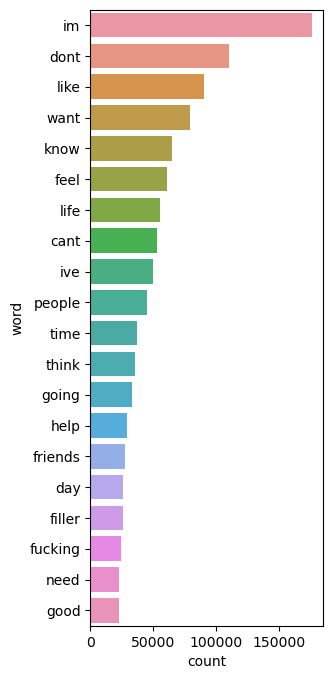

In [15]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

plt.figure(figsize=(3, 8))
sns.barplot(x='count',y='word',data=word_freq.iloc[:20])
plt.show()

## Ngrams

In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


stop=set(stopwords.words('english'))

corpus=[]
new= data['text'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olver\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<AxesSubplot:>

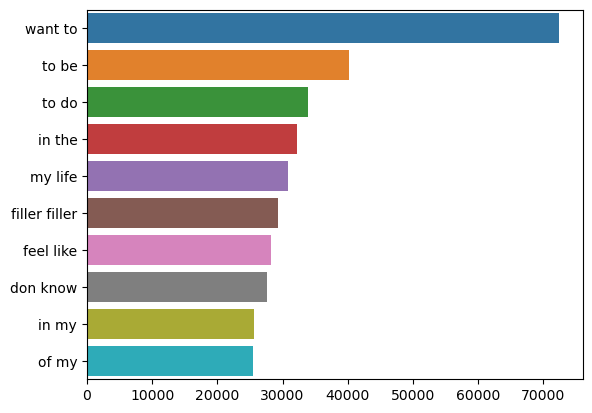

In [167]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

top_n_bigrams=get_top_ngram(data['text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)


<AxesSubplot:>

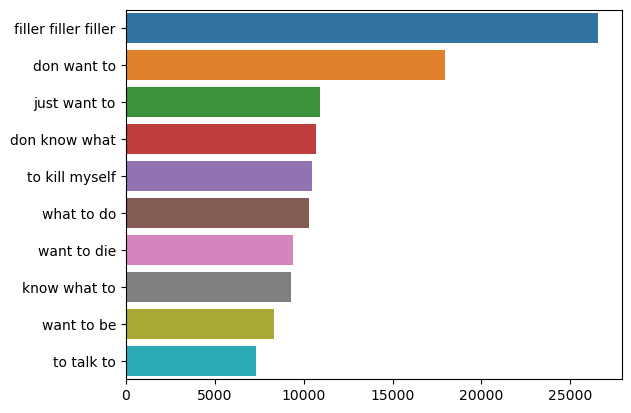

In [168]:
top_n_bigrams=get_top_ngram(data['text'],3)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

# Tokenizer

In [21]:
#cada post va a ser ahora un array donde los números son las palabras tokenizadas y ordenadas por frecuencia
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=1000)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=1000)

In [22]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)

#Buscamos el tamaño de la secuencia más larga
max_len=0
for i in train_text_seq:
    if len(i)>max_len:
        max_len=len(i)

In [23]:
l = LabelEncoder()
train_output = l.fit_transform(train_data['class'])
test_output = l.transform(test_data['class'])

In [24]:
#Cargamos glove embedding
path_glove = 'C:/Users/olver/OneDrive/Escritorio/Data_Suicide/glove.6B.300d.txt'

embeddings_index = {}
with open(path_glove) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [33]:
#Obtenemos el tamaño del vocabulario
tokens = len(tokenizer.word_index) + 2
embedding_dim = 300
hits = 0
misses = 0

#Creamos la matriz de embeddings
embedding_matrix = np.zeros((tokens, embedding_dim))
embeded_words = []

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        embeded_words.append(word)
        hits += 1
    else:
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))

Converted 50375 words (147116 misses)


# Visualization

In [128]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [129]:
embedding_layer = Embedding(
    tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

In [130]:
#creamos una red bidireccional
model=Sequential()
model.add(Input(shape=(1000,)))
model.add(embedding_layer)
model.add(Bidirectional(LSTM(32,return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(124,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [131]:
train_text_pad.shape

(161264, 1000)

In [132]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=8,batch_size=124,callbacks=[early_stop,reducelr])

Epoch 1/8
1301/1301 [==============================] - 273s 206ms/step - loss: 0.3166 - accuracy: 0.8687 - val_loss: 0.2418 - val_accuracy: 0.9047 - lr: 0.1000
Epoch 2/8
1301/1301 [==============================] - 181s 139ms/step - loss: 0.2427 - accuracy: 0.9032 - val_loss: 0.2297 - val_accuracy: 0.9090 - lr: 0.1000
Epoch 3/8
1301/1301 [==============================] - 215s 165ms/step - loss: 0.2251 - accuracy: 0.9117 - val_loss: 0.2127 - val_accuracy: 0.9175 - lr: 0.1000
Epoch 4/8
1301/1301 [==============================] - 216s 166ms/step - loss: 0.2111 - accuracy: 0.9179 - val_loss: 0.1989 - val_accuracy: 0.9232 - lr: 0.1000
Epoch 5/8
1301/1301 [==============================] - 186s 143ms/step - loss: 0.1972 - accuracy: 0.9238 - val_loss: 0.1893 - val_accuracy: 0.9274 - lr: 0.1000
Epoch 6/8
1301/1301 [==============================] - 187s 144ms/step - loss: 0.1814 - accuracy: 0.9303 - val_loss: 0.1838 - val_accuracy: 0.9295 - lr: 0.1000
Epoch 7/8
1301/1301 [===================

In [ ]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

1260/1260 [==============================] - 47s 37ms/step


<AxesSubplot:>

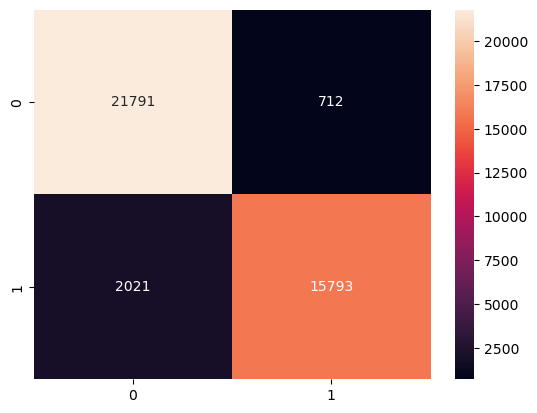

In [133]:
#imprimimos la matriz de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_text_pad)
y_pred = np.round(y_pred)
cm = confusion_matrix(test_output, y_pred)
sns.heatmap(cm, annot=True, fmt='d')


In [32]:
1175/21454

0.05476834156800597

In [135]:
#guardamos el modelo en la ruta donde estamos trabajando
model.save('model.h5')

In [39]:
#visualizamos el embedding 3D de las palabras usando t-SNE
from sklearn.manifold import TSNE

#embedding_matrix
#tokenizer.word_index.items():

tsne = TSNE(n_components=3, random_state=0)
words = embeded_words[:3000]
vectors = [embeddings_index[word] for word in words]
vectors_3d = tsne.fit_transform(vectors)

#creamos la grafica que podamos mover y le hacemos zoom para ver las palabras
fig = px.scatter_3d(
    vectors_3d, x=0, y=1, z=2, text=words, title='t-SNE 3D Embedding'
)
fig.update_traces(marker_size=5)
fig.show()



c:\Users\olver\anaconda3\envs\entornoGPU\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\olver\anaconda3\envs\entornoGPU\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [103]:
#porcentaje de post por clase 
data['class'].value_counts(normalize=True)

non-suicide    0.558153
suicide        0.441847
Name: class, dtype: float64